### Dependencies

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
from sklearn.preprocessing import normalize
import os
import math
from laserembeddings import Laser
import faiss
import itertools
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer, util # LaBSE sentence embedding model

### GPU

In [2]:
# Checks for GPU
if torch.cuda.is_available():
    print('Using GPU: {}'.format(torch.cuda.get_device_name(0)))
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU: Tesla V100-SXM2-16GB


### Loading embedding models

In [4]:
laser_model = Laser()
if torch.cuda.is_available():
    print('Using GPU for LASER embeddings')
else:
    print('Using CPU for LASER embeddings')

Using GPU for LASER embeddings


In [5]:
# Loading LaBSE sentence embedding model
labse_model = SentenceTransformer('LaBSE')
labse_model.cuda() # puts model on GPU

SentenceTransformer(
  (0): Transformer(
    (auto_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(501153, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
      

### Embedding sentences using LaBSE and LASER

### Configuring bitext retrieval task

In [8]:
GPU = faiss.StandardGpuResources() # enables GPU for similarity search with FAISS

In [7]:
'''

Params
******
src_emb: array of size number_of_source_sentences X embedding_dimension
tgt_emb: array of size number_of_target_sentences X embedding_dimension
k: number of neighbors to return
batch_size: batch size

Returns
*******
cos_sims: cosine similarity scores for each of k nearest neighbors for each source sentence
inds: target indices of k nearest neighbors for each source sentence

Modeled off of LASER source code: https://github.com/facebookresearch/LASER/blob/master/source/mine_bitexts.py

'''

def knnSearch(src_emb, tgt_emb, k=1, batch_size=1):
    emb_dim = src_emb.shape[1] # Embedding dimension
    num_src_sents = src_emb.shape[0]
    num_tgt_sents = tgt_emb.shape[0]
    cos_sims = np.zeros((num_src_sents, k), dtype=np.float32)
    inds = np.zeros((num_src_sents, k), dtype=np.int64)
    for s_min in range(0, num_src_sents, batch_size):
        s_max = min(s_min + batch_size, num_src_sents)
        src_sims = []
        src_inds = []
        for t_min in range(0, num_tgt_sents, batch_size):
            t_max = min(t_min + batch_size, num_tgt_sents)
            idx = faiss.IndexFlatIP(emb_dim)
            idx = faiss.index_cpu_to_gpu(GPU, 0, idx)
            idx.add(tgt_emb[t_min : t_max])
            src_sim, src_ind = idx.search(src_emb[s_min : s_max], min(k, t_max-t_min))
            src_sims.append(src_sim)
            src_inds.append(src_ind + t_min)
            del idx
        src_sims = np.concatenate(src_sims, axis=1)
        src_inds = np.concatenate(src_inds, axis=1)
        sorted_inds = np.argsort(-src_sims, axis=1)
        for i in range(s_min, s_max):
            for j in range(k):
                cos_sims[i, j] = src_sims[i-s_min, sorted_inds[i-s_min, j]]
                inds[i, j] = src_inds[i-s_min, sorted_inds[i-s_min, j]]
    return cos_sims, inds

In [9]:
# Retrieves k-nearest neighbor indices and similarity means for margin scoring
# If forward: finds neearest neighbors and indices for all source sentences
# If backward: finds nearest neighbors and indices for all target sentences
# In the approach implemented in our paper, we perform both forward and backward search

def directedMeansAndInds(src_emb, tgt_emb, forward=False, backward=False, k=1, batch_size=1):
    assert forward != backward, "Please choose either forward or backward"
    if forward:
        cos_sims, inds = knnSearch(src_emb, tgt_emb, min(tgt_emb.shape[0], k), batch_size)
        return cos_sims.mean(axis=1), inds
    elif backward:
        cos_sims, inds = knnSearch(tgt_emb, src_emb, min(src_emb.shape[0], k), batch_size)
        return cos_sims.mean(axis=1), inds

In [10]:
'''

Params
******
pred_tuples: predicted sentence pairs
gold_tuples: ground-truth sentence pairs

Returns
*******
Unweighted F1, precision, recall

'''

def computeF1(pred_tuples, gold_tuples):
    tp = 0 # true positives
    fp = 0 # false positives
    prec = 0
    rec = 0
    f1 = 0
    epsilon = 1e-8 # To prevent division by zero
    for pair in pred_tuples:
        if pair in gold_tuples:
            tp += 1
        else:
            fp += 1 
    prec = tp / (len(pred_tuples) + epsilon)
    rec = tp / len(gold_tuples)
    f1 = 2*prec*rec / (prec+rec+epsilon)
    return f1, prec, rec

In [11]:
'''

Params
******
src_embs: array of size (number_of_source_sentences * embedding_dimension)
tgt_embs: array of size (number_of_source_sentences * embedding_dimension)
batch_size: batch size
num_neighbors: number of neighbors
average: whether to return a force-aligned average margin score

Returns
*******
concat_pairs: list of mined sentence pairs
margin_scores: list of scores corresponding to mined pairs

'''


def mineSentencePairs(src_embs: list, tgt_embs: list, batch_size=100, num_neighbors=4, average=False):

    # Retrieve means and indices in the forward direction . . .
    fwd_means, fwd_inds = directedMeansAndInds(src_embs, tgt_embs, forward=True, k=num_neighbors, batch_size=batch_size)
    # . . . and in the backward direction
    bwd_means, bwd_inds = directedMeansAndInds(src_embs, tgt_embs, backward=True, k=num_neighbors, batch_size=batch_size)

    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    # We'll sneak this in as an extra capability of this function so we can compute 
    # average margin scores over force-aligned sentence pairs (DV #2)
    margin_scores_aligned = []
    if average:
        for i in range(fwd_inds.shape[0]):
            aligned_margin = (src_embs[i].dot(tgt_embs[i])) / np.average((fwd_means[i], bwd_means[i]))
            margin_scores_aligned.append(aligned_margin)
        return np.average(margin_scores_aligned)
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    
    # else . . .
    fwd_margin_scores = np.zeros(fwd_inds.shape)
    for i in range(fwd_inds.shape[0]):
        for j in range(fwd_inds.shape[1]):
            tgt_ind = fwd_inds[i,j]
            # Compute ratio margin score between each source sentence and each of its k-nearest neighbors
            margin_score = (src_embs[i].dot(tgt_embs[tgt_ind])) / np.average((fwd_means[i], bwd_means[tgt_ind]))
            # Store the result
            fwd_margin_scores[i,j] = margin_score
    
    # We will store the source index, target index, and margin score for the best
    # pairs found using forward search
    best = np.zeros((fwd_inds.shape[0], 3))
    # Take pair that maximizes margin score for each source sentence
    best_inds = fwd_inds[np.arange(src_embs.shape[0]), fwd_margin_scores.argmax(axis=1)]
    for i in range(fwd_inds.shape[0]):
        best_score, ind = (np.max(fwd_margin_scores[i]), np.argmax(fwd_margin_scores[i]))
        best[i] = ((i+1, best_inds[i]+1, best_score)) # Assumption is that GROUND TRUTH VALUES ARE 1-INDEXED!!!

    # Repeat process in backward direction (finding matches in source text for target sentences)
    bwd_margin_scores = np.zeros(bwd_inds.shape)
    for i in range(bwd_inds.shape[0]):
        for j in range(bwd_inds.shape[1]):
            tgt_ind = bwd_inds[i,j]
            margin_score = (tgt_embs[i].dot(src_embs[tgt_ind])) / np.average((bwd_means[i], fwd_means[tgt_ind]))
            bwd_margin_scores[i,j] = margin_score
            
    bwd_best = np.zeros((bwd_inds.shape[0], 3))
    best_inds = bwd_inds[np.arange(tgt_embs.shape[0]), bwd_margin_scores.argmax(axis=1)]
    for i in range(bwd_inds.shape[0]):
        best_score, ind = (np.max(bwd_margin_scores[i]), np.argmax(bwd_margin_scores[i]))
        bwd_best[i] = ((best_inds[i]+1, i+1, best_score))
    
    # Best triples (src_idx, tgt_idx, margin_score) from forward/backward searches
    fwd_best = [tuple(best[i]) for i in range(best.shape[0])]
    bwd_best = [tuple(bwd_best[i]) for i in range(bwd_best.shape[0])]

    pairs_and_scores = []
    # Take INTERSECTION of forward and backward searches
    pairs_and_scores = list(set(fwd_best) & set(bwd_best))

    pairs_and_scores = list(dict.fromkeys(pairs_and_scores))
    concat_pairs = [(triplet[0], triplet[1]) for triplet in pairs_and_scores] # Store indices only
    concat_pairs_int = []
    for tup in concat_pairs:
        concat_pairs_int.append((int(tup[0]), int(tup[1]))) # Ground-truth indices are ints, so change type
    concat_pairs = concat_pairs_int

    margin_scores = [triplet[2] for triplet in pairs_and_scores] # Store scores only

    return concat_pairs, margin_scores

### Comparing F1-scores on the bitext mining task

## Morphological segmentation experiment

In [12]:
# English half of Hansard English-Inuktitut parallel corpus
eng_iku_EN = open('Data/english-inuktitut.eng', 'r').read().splitlines()
# Inuktitut half of the same corpus
eng_iku_IK = open('Data/english-inuktitut.iku', 'r').read().splitlines()
# Morphologically segmented subset of the above set of Inuktitut texts
eng_iku_IK_seg = open('Data/inuktitut_segmented.txt', 'r').read().splitlines()

In [16]:
# We'll only use this many sentences, since this many have been morphologically parsed
IKU_SENTS_TO_KEEP = len(eng_iku_IK_seg)

In [17]:
eng_iku_EN = eng_iku_EN[:IKU_SENTS_TO_KEEP-1]
eng_iku_IK = eng_iku_IK[:IKU_SENTS_TO_KEEP-1]
eng_iku_IK_seg = eng_iku_IK_seg[:-1]

In [18]:
print('Number of English-Inuktitut parallel sentences: {}'.format(len(eng_iku_IK)))

Number of English-Inuktitut parallel sentences: 112190


In [19]:
eng_iku_en_embs_labse = labse_model.encode(eng_iku_EN[:10000])
eng_iku_ik_embs_labse = labse_model.encode(eng_iku_IK[:10000])
eng_iku_ik_seg_embs_labse = labse_model.encode(eng_iku_IK_seg[:10000])

In [20]:
eng_iku_en_embs_laser = laser_model.embed_sentences(eng_iku_EN[:10000], 'en')
eng_iku_ik_embs_laser = laser_model.embed_sentences(eng_iku_IK[:10000], '')
eng_iku_ik_seg_embs_laser = laser_model.embed_sentences(eng_iku_IK_seg[:10000], '')

In [21]:
## LaBSE
# Non-segmented
en_ik_pairs_labse, _ = mineSentencePairs(eng_iku_en_embs_labse, eng_iku_ik_embs_labse)
# Segmented
en_ik_pairs_seg_labse, _ = mineSentencePairs(eng_iku_ik_embs_labse, eng_iku_ik_seg_embs_labse)

In [22]:
## LASER
# Non-segmented
en_ik_pairs_laser, _ = mineSentencePairs(eng_iku_en_embs_laser, eng_iku_ik_embs_laser)
# Segmented
en_ik_pairs_seg_laser, _ = mineSentencePairs(eng_iku_en_embs_laser, eng_iku_ik_seg_embs_laser)

In [23]:
en_ik_ground_truth = [(i+1,i+1) for i in range(10000)]

In [24]:
res1 = computeF1(en_ik_pairs_labse, en_ik_ground_truth)[0]

In [25]:
res2 = computeF1(en_ik_pairs_seg_labse, en_ik_ground_truth)[0]

In [26]:
res3 = computeF1(en_ik_pairs_laser, en_ik_ground_truth)[0]

In [27]:
res4 = computeF1(en_ik_pairs_seg_laser, en_ik_ground_truth)[0]

In [28]:
print('English-Inuktitut bitext retrieval F1-score (LaBSE, non-segmented): {}'.format(100*round(res1, 5)))
print('English-Inuktitut bitext retrieval F1-score (LaBSE, segmented): {}'.format(100*round(res2, 5)))
print('English-Inuktitut bitext retrieval F1-score (LASER, non-segmented): {}'.format(100*round(res3, 5)))
print('English-Inuktitut bitext retrieval F1-score (LASER, segmented): {}'.format(100*round(res4, 5)))

English-Inuktitut bitext retrieval F1-score (LaBSE, non-segmented): 6.710000000000001
English-Inuktitut bitext retrieval F1-score (LaBSE, segmented): 35.447
English-Inuktitut bitext retrieval F1-score (LASER, non-segmented): 0.08
English-Inuktitut bitext retrieval F1-score (LASER, segmented): 0.12


In [29]:
en_ik_results_labse = pd.DataFrame([res1, res2], columns=['F1-score'], 
                             index=['LaBSE (non-segmented)',
                                    'LaBSE (segmented)'])

In [30]:
en_ik_results_laser = pd.DataFrame([res3, res4], columns=['F1-score'], 
                             index=['LASER (non-segmented)',
                                    'LASER (segmented)'])

<AxesSubplot:xlabel='Text type', ylabel='F1-score'>

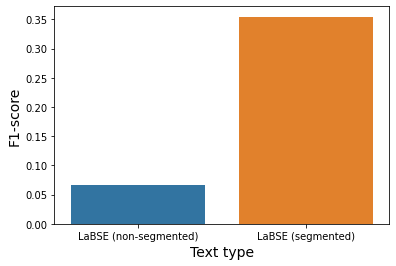

In [31]:
plt.xlabel('Text type', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
sns.barplot(data=en_ik_results_labse, x=['LaBSE (non-segmented)', 'LaBSE (segmented)'], y='F1-score')

<AxesSubplot:xlabel='Text type', ylabel='F1-score'>

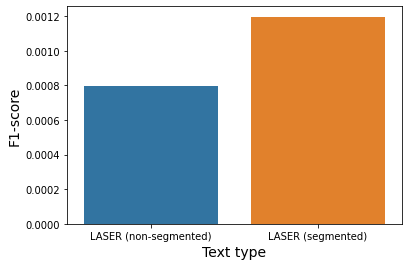

In [32]:
plt.xlabel('Text type', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
sns.barplot(data=en_ik_results_laser, x=['LASER (non-segmented)', 'LASER (segmented)'], y='F1-score')

# Word order agreement experiment

### PCA

In [12]:
kiiche_udhr = open('Data/UDHR/kiiche.txt', 'r').read().splitlines()
mam_udhr = open('Data/UDHR/mam.txt', 'r').read().splitlines()
chickasaw_udhr = open('Data/UDHR/chickasaw.txt', 'r').read().splitlines()
quechua_udhr = open('Data/UDHR/quechua.txt', 'r').read().splitlines()

In [13]:
def getSents(file: list, delimiter='.', strip=False):
    out = []
    for par in file:
        for s in par.split(delimiter):
            if s:
                out.append(s)
    return out

In [14]:
kiiche_sents = getSents(kiiche_udhr)
mam_sents = getSents(mam_udhr)
chickasaw_sents = getSents(chickasaw_udhr)
quechua_sents = getSents(quechua_udhr)

In [15]:
kiiche_embs_labse = labse_model.encode(kiiche_sents)
mam_embs_labse = labse_model.encode(mam_sents)
chickasaw_embs_labse = labse_model.encode(chickasaw_sents)
quechua_embs_labse = labse_model.encode(quechua_sents)

In [16]:
kiiche_embs_laser = laser_model.embed_sentences(kiiche_sents, '')
mam_embs_laser = laser_model.embed_sentences(mam_sents, '')
chickasaw_embs_laser = laser_model.embed_sentences(chickasaw_sents, '')
quechua_embs_laser = laser_model.embed_sentences(quechua_sents, '')

In [18]:
kiiche_pca_labse = PCA(n_components=2).fit_transform(kiiche_embs_labse)
mam_pca_labse = PCA(n_components=2).fit_transform(mam_embs_labse)
chickasaw_pca_labse = PCA(n_components=2).fit_transform(chickasaw_embs_labse)
quechua_pca_labse = PCA(n_components=2).fit_transform(quechua_embs_labse)

kiiche_pca_laser = PCA(n_components=2).fit_transform(kiiche_embs_laser)
mam_pca_laser = PCA(n_components=2).fit_transform(mam_embs_laser)
chickasaw_pca_laser = PCA(n_components=2).fit_transform(chickasaw_embs_laser)
quechua_pca_laser = PCA(n_components=2).fit_transform(quechua_embs_laser)

In [25]:
pca_sov_langs = 111*['Chickasaw (SOV)'] + 108*['Quechua (SOV)']
pca_nonsov_langs = 107*['K\'iche (VOS)']+97*['Mam (VSO)']

In [144]:
pc1_labse_sov = list(chickasaw_pca_labse[:,0])+list(quechua_pca_labse[:,0])

In [170]:
pc1_labse_nonsov = list(kiiche_pca_labse[:,0])+list(mam_pca_labse[:,0])

In [145]:
pc2_labse_sov = list(chickasaw_pca_labse[:,1])+list(quechua_pca_labse[:,1])

In [171]:
pc2_labse_nonsov = list(kiiche_pca_labse[:,1])+list(mam_pca_labse[:,1])

In [146]:
pc1_laser_sov = list(chickasaw_pca_laser[:,0])+list(quechua_pca_laser[:,0])

In [172]:
pc1_laser_nonsov = list(kiiche_pca_laser[:,0])+list(mam_pca_laser[:,0])

In [147]:
pc2_laser_sov = list(chickasaw_pca_laser[:,1])+list(quechua_pca_laser[:,1])

In [173]:
pc2_laser_nonsov = list(kiiche_pca_laser[:,1])+list(mam_pca_laser[:,1])

In [174]:
pca_df_labse_sov = pd.DataFrame({'PC1 (LaBSE)':pc1_labse_sov, 'PC2 (LaBSE)':pc2_labse_sov, 'Language':pca_sov_langs})

In [175]:
pca_df_labse_nonsov = pd.DataFrame({'PC1 (LaBSE)':pc1_labse_nonsov, 'PC2 (LaBSE)':pc2_labse_nonsov, 'Language':pca_nonsov_langs})

In [176]:
pca_df_laser_sov = pd.DataFrame({'PC1 (LASER)':pc1_laser_sov, 'PC2 (LASER)':pc2_laser_sov, 'Language':pca_sov_langs})

In [177]:
pca_df_laser_nonsov = pd.DataFrame({'PC1 (LASER)':pc1_laser_nonsov, 'PC2 (LASER)':pc2_laser_nonsov, 'Language':pca_nonsov_langs})

<AxesSubplot:xlabel='PC1 (LaBSE)', ylabel='PC2 (LaBSE)'>

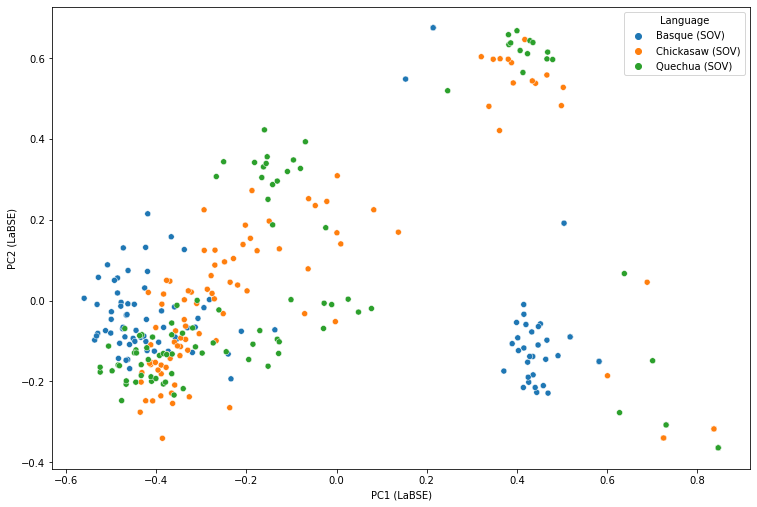

In [149]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=pca_df_labse_sov, x='PC1 (LaBSE)', y='PC2 (LaBSE)', hue='Language')

<AxesSubplot:xlabel='PC1 (LASER)', ylabel='PC2 (LASER)'>

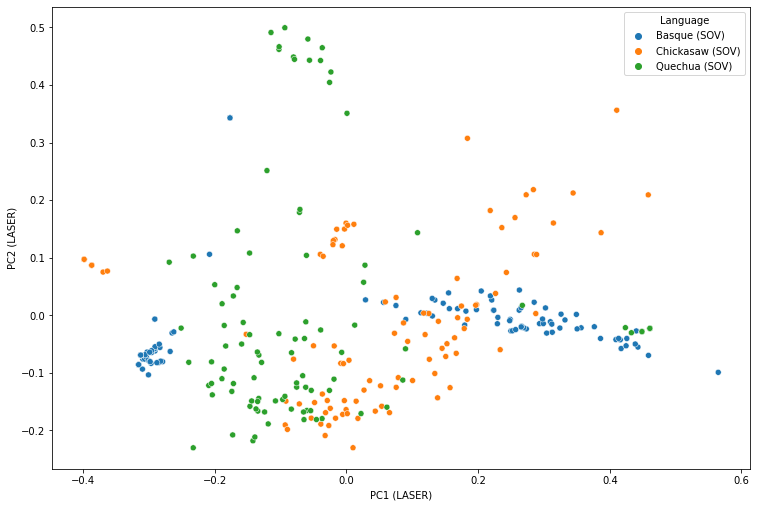

In [153]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=pca_df_laser_sov, x='PC1 (LASER)', y='PC2 (LASER)', hue='Language')

<AxesSubplot:xlabel='PC1 (LaBSE)', ylabel='PC2 (LaBSE)'>

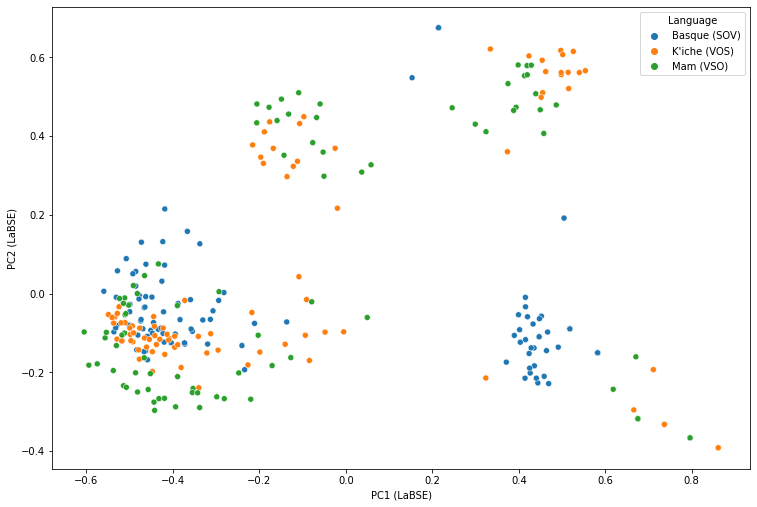

In [179]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=pca_df_labse_nonsov, x='PC1 (LaBSE)', y='PC2 (LaBSE)', hue='Language')

<AxesSubplot:xlabel='PC1 (LASER)', ylabel='PC2 (LASER)'>

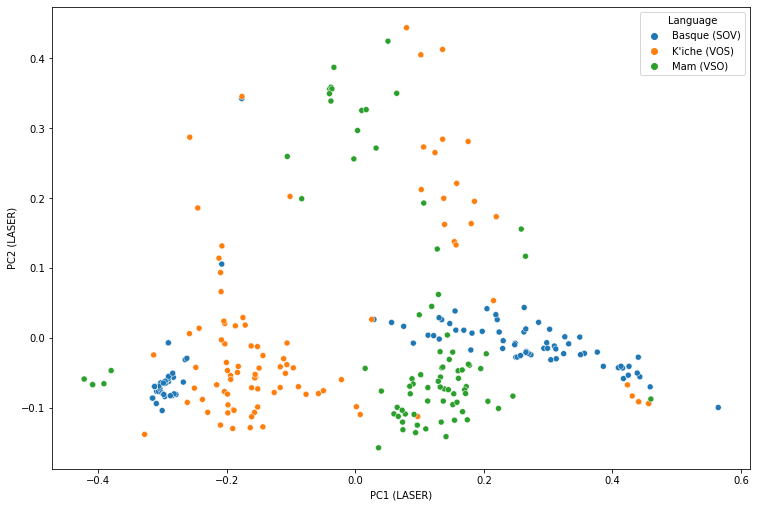

In [180]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=pca_df_laser_nonsov, x='PC1 (LASER)', y='PC2 (LASER)', hue='Language')

### t-SNE

In [62]:
kiiche_tsne_labse = TSNE().fit_transform(kiiche_embs_labse)
mam_tsne_labse = TSNE().fit_transform(mam_embs_labse)
chickasaw_tsne_labse = TSNE().fit_transform(chickasaw_embs_labse)
quechua_tsne_labse = TSNE().fit_transform(quechua_embs_labse)

kiiche_tsne_laser = TSNE().fit_transform(kiiche_embs_laser)
mam_tsne_laser = TSNE().fit_transform(mam_embs_laser)
chickasaw_tsne_laser = TSNE().fit_transform(chickasaw_embs_laser)
quechua_tsne_laser = TSNE().fit_transform(quechua_embs_laser)

In [63]:
tsne1_labse_sov = list(chickasaw_tsne_labse[:,0])+list(quechua_tsne_labse[:,0])
tsne1_labse_nonsov = list(kiiche_tsne_labse[:,0])+list(mam_tsne_labse[:,0])

tsne2_labse_sov = list(chickasaw_tsne_labse[:,1])+list(quechua_tsne_labse[:,1])
tsne2_labse_nonsov = list(kiiche_tsne_labse[:,1])+list(mam_tsne_labse[:,1])

tsne1_laser_sov = list(chickasaw_tsne_laser[:,0])+list(quechua_tsne_laser[:,0])
tsne1_laser_nonsov = list(kiiche_tsne_laser[:,0])+list(mam_tsne_laser[:,0])

tsne2_laser_sov = list(chickasaw_tsne_laser[:,1])+list(quechua_tsne_laser[:,1])
tsne2_laser_nonsov = list(kiiche_tsne_laser[:,1])+list(mam_tsne_laser[:,1])

In [64]:
tsne_df_labse_sov = pd.DataFrame({'t-SNE1 (LaBSE)':tsne1_labse_sov, 
                                 't-SNE2 (LaBSE)':tsne2_labse_sov, 
                                 'Language':pca_sov_langs[127:]})
tsne_df_labse_nonsov = pd.DataFrame({'t-SNE1 (LaBSE)':tsne1_labse_nonsov, 
                                    't-SNE2 (LaBSE)':tsne2_labse_nonsov, 
                                    'Language':pca_nonsov_langs[127:]})
tsne_df_laser_sov = pd.DataFrame({'t-SNE1 (LASER)':tsne1_laser_sov, 
                                 't-SNE2 (LASER)':tsne2_laser_sov, 
                                 'Language':pca_sov_langs[127:]})
tsne_df_laser_nonsov = pd.DataFrame({'t-SNE1 (LASER)':tsne1_laser_nonsov, 
                                    't-SNE2 (LASER)':tsne2_laser_nonsov, 
                                    'Language':pca_nonsov_langs[127:]})

<AxesSubplot:xlabel='t-SNE1 (LaBSE)', ylabel='t-SNE2 (LaBSE)'>

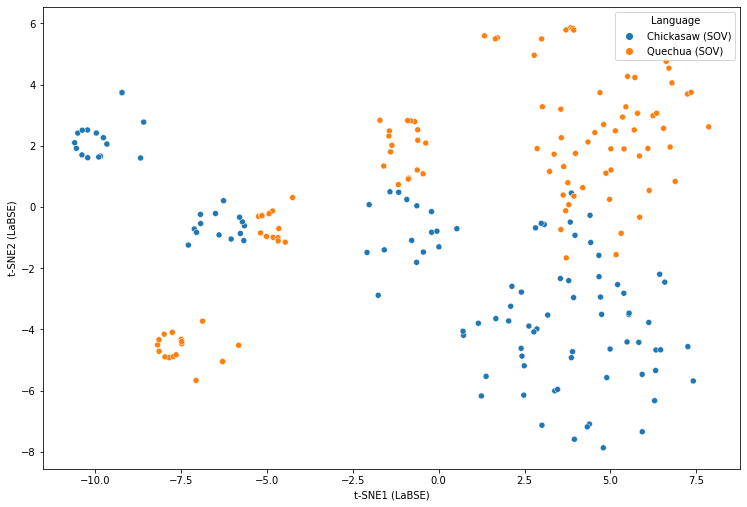

In [65]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=tsne_df_labse_sov, x='t-SNE1 (LaBSE)', y='t-SNE2 (LaBSE)', hue='Language')

<AxesSubplot:xlabel='t-SNE1 (LASER)', ylabel='t-SNE2 (LASER)'>

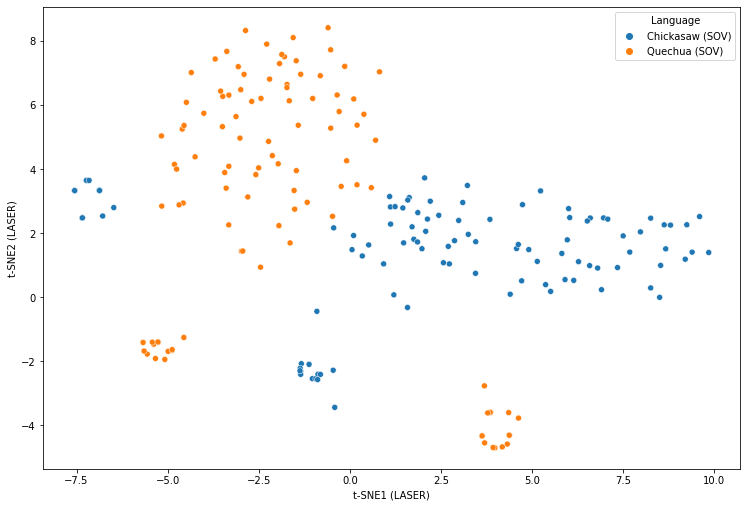

In [66]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=tsne_df_laser_sov, x='t-SNE1 (LASER)', y='t-SNE2 (LASER)', hue='Language')

<AxesSubplot:xlabel='t-SNE1 (LaBSE)', ylabel='t-SNE2 (LaBSE)'>

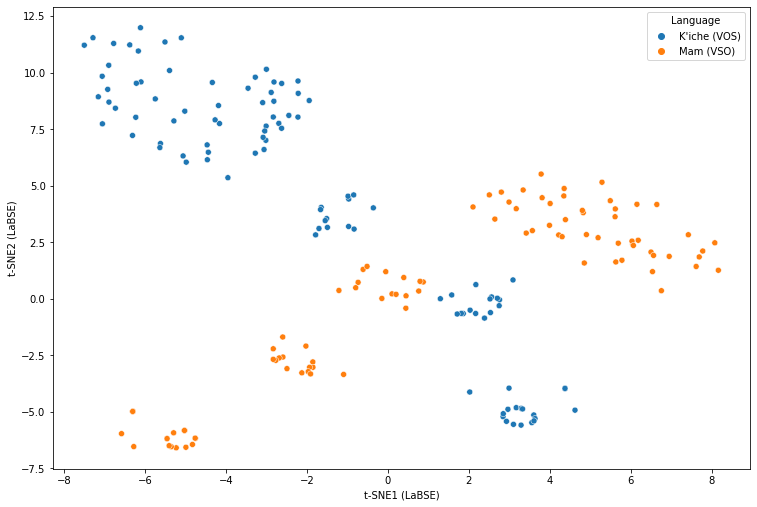

In [67]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=tsne_df_labse_nonsov, x='t-SNE1 (LaBSE)', y='t-SNE2 (LaBSE)', hue='Language')

<AxesSubplot:xlabel='t-SNE1 (LASER)', ylabel='t-SNE2 (LASER)'>

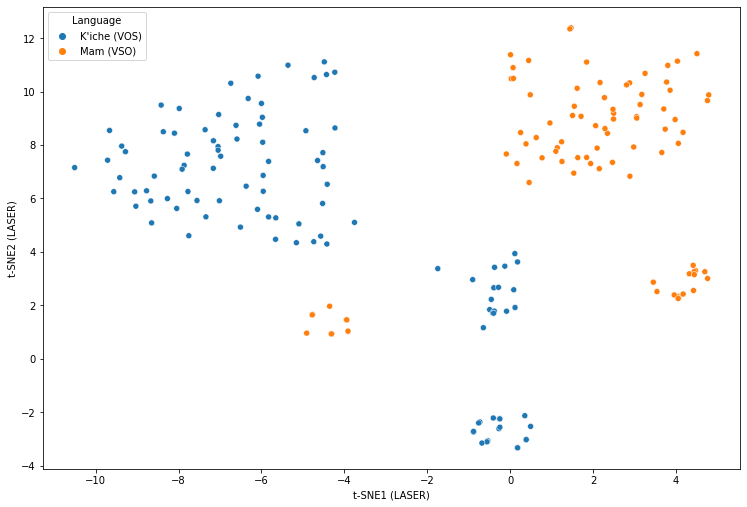

In [39]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5)
sns.scatterplot(data=tsne_df_laser_nonsov, x='t-SNE1 (LASER)', y='t-SNE2 (LASER)', hue='Language')